## Cholesky decomposition errors.  
gully  
February 2016

Starfish error #26 shows that there is some strange Cholesky-decomposition rounding error problem.  In this demo, we will try to recreate the problem, characterize it, and solve it.

### What do we know

- It tends to crop up when there are extreme ratios of the on-diagonal and off-diagonal terms of the covariance matrix.
- It has occurred for several users.
- It has to do with the Cholesky decomposition step.
- Similar problems have been reported in other repositories, with alleged fixes.

### Reproducing it.
It last occured for me when I tried to fit a synthetic mixture model spectrum.  

Let's try fitting synthetic data for IGRINS order $m = 86$ in the `welter` repository.

We will perform the normal sequence of steps:

- `star.py --optimize=Theta`
- `theta_into_config.py`
- `star.py --optimize=Cheb`
- `star.py --generate`
- `splot.py s0_o0spec.json --matplotlib --noise`

Here's what it looks like:

<img src='s0_o0spec.json.png'>

Now comes the problematic step, sampling.  The problem has to do with the covariance matrix, which is the $\Phi$ parameter in Czekala et al. 2015.  So sampling with `ThetaCheb` works fine, but sampling with `ThetaPhi` causes errors.

- `star.py --sample=ThetaPhi --samples=100` 

As Ian noted, this is tricky to debug because you have to run the MCMC in parallel and just hope that you can catch one of the problems.  Luckily for us, the problem occurred after only about 30 samples:

```python
Traceback (most recent call last):
  File "/anaconda/lib/python3.4/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/anaconda/lib/python3.4/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 541, in brain
    alive = self.interpret()
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 559, in interpret
    response = func(arg)
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 433, in decide_Theta
    self.independent_sample(1)
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 518, in independent_sample
    self.p0, self.lnprob, state = self.sampler.run_mcmc(pos0=self.p0, N=niter, lnprob0=self.lnprob)
  File "/anaconda/lib/python3.4/site-packages/emcee/sampler.py", line 157, in run_mcmc
    **kwargs):
  File "/Users/gully/GitHub/Starfish/Starfish/samplers.py", line 150, in sample
    newlnprob = self.get_lnprob(q)
  File "/anaconda/lib/python3.4/site-packages/emcee/sampler.py", line 116, in get_lnprob
    return self.lnprobfn(p, *self.args, **self.kwargs)
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 696, in lnfunc
    lnp = self.evaluate()
  File "/Users/gully/GitHub/Starfish/Starfish/parallel.py", line 297, in evaluate
    factor, flag = cho_factor(CC)
  File "/anaconda/lib/python3.4/site-packages/scipy/linalg/decomp_cholesky.py", line 132, in cho_factor
    check_finite=check_finite)
  File "/anaconda/lib/python3.4/site-packages/scipy/linalg/decomp_cholesky.py", line 30, in _cholesky
    raise LinAlgError("%d-th leading minor not positive definite" % info)
numpy.linalg.linalg.LinAlgError: 3-th leading minor not positive definite
```

## Debugging.
Where do we start?

The `log.log` file isn't much help.  
How could we "jump into" the operation of the code?  I want to have the code tell me what's wrong.  

What I could do is wrap the cholesky decomposition call inside a `try/except` block.  Let's do that...

The main problem is around line 297 of the `parallel.py` code:
    
```python
try:
    factor, flag = cho_factor(CC)
except np.linalg.linalg.LinAlgError:
    print('---------------------------------------------------')
    CC.tofile('CC_test.npy')
```

I've saved the problematic CC matrix to a npy file.  So now we don't have to worry about the high development cycle overhead.  We can experiment right here.

In [1]:
import numpy as np

In [2]:
CC_1d = np.fromfile('CC_test.npy')

In [3]:
CC_1d.shape

(2250000,)

It *should* be (1500, 1500)

In [4]:
CC = CC_1d.reshape((1500, 1500))

In [5]:
CC.shape

(1500, 1500)

### Plots

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import seaborn as sns
import matplotlib.pyplot as plt

Let's look at the problematic matrix:

In [7]:
#sns.heatmap(CC, xticklabels=False, yticklabels=False)

It *looks* like the covariance matrix consists only of on- or near- diagonal terms.  But there are negative values.  Why?  And where are they?

In [8]:
diff = (CC - np.abs(CC))/2.0

In [9]:
#sns.heatmap(diff, xticklabels=False, yticklabels=False)

A-ha!  The negative values are coming from the spectral emulator covariance parameters.  I think it's OK to have negative covariance parameters on large scales-- "The lines over here are *negatively* correlated with the ones over there."  But I think the matrix must be *symmetric*, meaning the values in the upper right triangular matrix are equal to the values in the lower left triangular matrix.  The matrix *looks* symmetric.

Let's multiply the negative values by 1000 to put them in the context of the on-diagonal terms.

In [10]:
#sns.heatmap(diff*1001.0+np.abs(CC), xticklabels=False, yticklabels=False)

In [11]:
from scipy.linalg import cho_factor, cho_solve

Reproduce the problem:

In [12]:
factor, flag = cho_factor(CC)

LinAlgError: 3-th leading minor not positive definite

In [13]:
from scipy.linalg import cholesky

In [14]:
np.linalg.linalg.cholesky(CC)

LinAlgError: Matrix is not positive definite

In [15]:
evals, evecs = np.linalg.eigh(CC)

In [16]:
evals

array([-0.00014183, -0.00013704, -0.00013286, ...,  0.00291626,
        0.00297058,  0.00303476])

A ha! Negative eigenvalues!

## What does a healthy matrix look like?

In [17]:
HH_1d = np.fromfile('CC_healthy.npy')

In [18]:
HH = HH_1d.reshape((1500,1500))

In [19]:
factor, flag = cho_factor(HH)

In [20]:
sgn, val = np.linalg.slogdet(HH)

In [21]:
val

-18008.832207527623

In [22]:
#sns.heatmap(HH, xticklabels=False, yticklabels=False)

It must have a few large values hidden in there.

In [23]:
diff_HH = HH - np.abs(HH)

In [24]:
##sns.heatmap(diff_HH, xticklabels=False, yticklabels=False)

Looks about the same as the unhealthy matrix.  

Makes sense, since the eigenspectra haven't really changed (although their weights might have changed a little between samplings).

In [25]:
evals_HH, evecs_HH = np.linalg.eigh(HH)

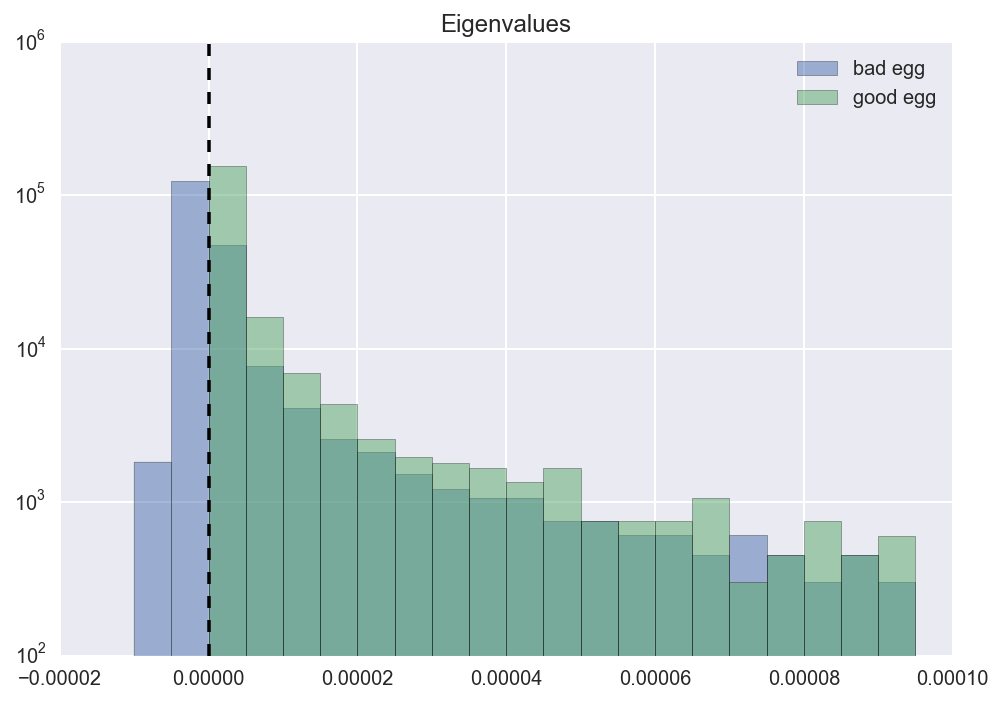

In [26]:
xbins = np.arange(-1.0E-5, 1.0E-4, 5.0E-6)

plt.hist(evals, bins=xbins, normed=True, log=True, alpha = 0.5, label = 'bad egg')
plt.hist(evals_HH, bins=xbins, normed=True, log=True, alpha = 0.5, label = 'good egg')

plt.plot([0, 0], [0, 1.0E6], 'k--')
plt.title('Eigenvalues')
plt.legend()

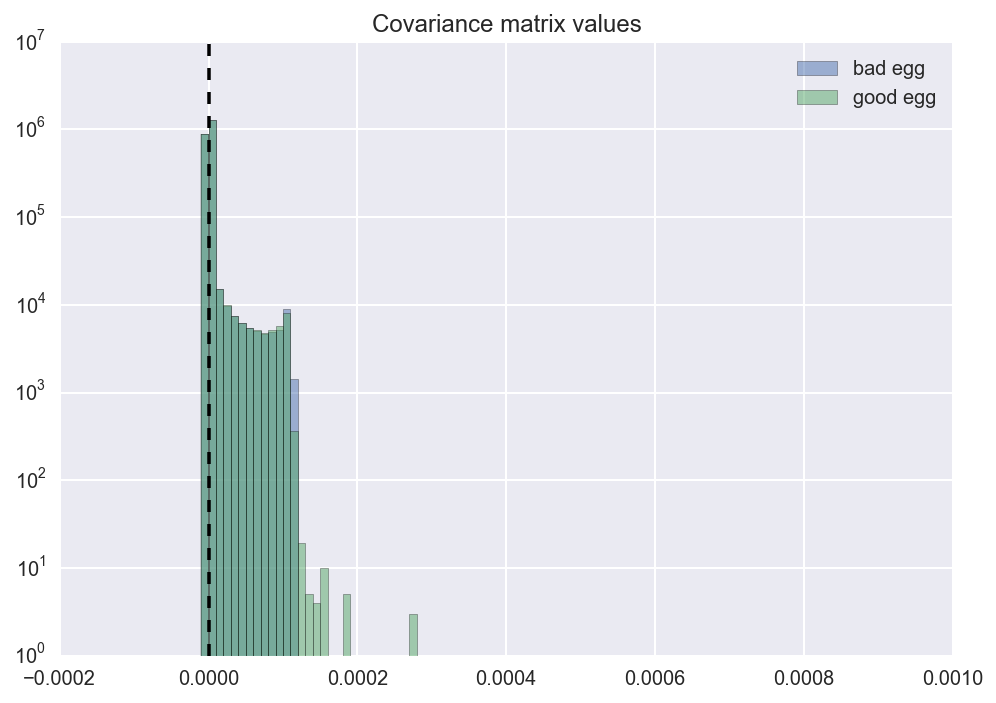

In [27]:
xbins = np.arange(-1.0E-5, 1.0E-3, 1.0E-5)

plt.hist(CC_1d, bins=xbins, log=True, alpha = 0.5, label = 'bad egg')
plt.hist(HH_1d, bins=xbins, log=True, alpha = 0.5, label = 'good egg')
plt.plot([0, 0], [0, 1.0E7], 'k--')
plt.legend()
plt.title('Covariance matrix values');

Almost identical, but some large values in the matrix that works.

In [28]:
diags_H = HH.diagonal()
diags_C = CC.diagonal()

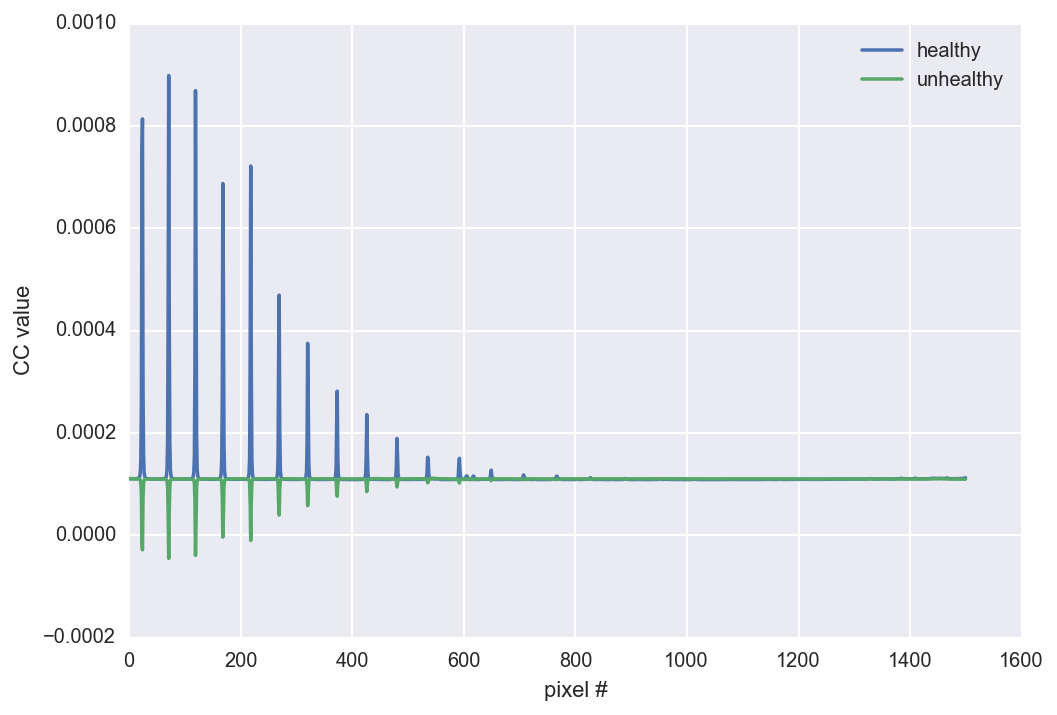

In [29]:
plt.plot(diags_H, label='healthy')
plt.plot(diags_C, label='unhealthy' )
plt.xlabel('pixel #')
plt.ylabel('CC value')
plt.legend()

### There's the problem!! 

We have **negative** diagonal elements on the covariance matrix.  

A little snooping reveals that `sigAmp` has no a-priori probability density distribution function assigned to it.  In other words, it is allowed to be negative.  A negative `sigAmp` translates directly into negative on-diagonal terms and therefore an unphysical/undefined correlation matrix.

My solution is to fix this is to assign a *prior* on `sigAmp`.  I did this by changing the `lnfunc()` function in the `SampleThetaPhi` Class that returns the natural log likelihood given a set of parameters.  It feeds this function into the sampler.  Here is my edit:

```python
def lnfunc(p):
    # Convert p array into a PhiParam object
    ind = self.npoly
    if self.chebyshevSpectrum.fix_c0:
        ind -= 1

    cheb = p[0:ind]
    sigAmp = p[ind]
    ind+=1
    logAmp = p[ind]
    ind+=1
    l = p[ind]

    # Here is where we set the Priors on the Phi parameters:
    # The only prior right now is that the sigAmp must be positive.
    # We could also put priors on the Chebyshev polynomial coefficients, etc...
    # This can also be a continuous function of p
    if not (0.0 < sigAmp): #More conditionals here...
        lnprior = -np.inf
        return -np.inf #Circumvent execution of the expen$ive `evaluate()` function...
    else:
        lnprior = 0.0

    par = PhiParam(self.spectrum_id, self.order, self.chebyshevSpectrum.fix_c0, cheb, sigAmp, logAmp, l)

    self.update_Phi(par)

    lnp = self.evaluate()
    self.logger.debug("Evaluated Phi parameters: {} {}".format(par, lnp))
    return lnp + lnprior
```

# The end.